# NLP with disaster tweets (on Kaggle)

This is a knowledge competition on Kaggle. The goal is to predict which tweets are about real disasters and which ones are not.  

In this notebook, I compared different models for classifying disaster and non-disater tweets. I also tried to combine different models to make predictions. In the end, I found that transformers BERT model performed the best.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
print(tf.__version__)

2.9.2


### Read data into DataFrame

In [4]:
path = "/content/drive/MyDrive/Colab Notebooks/DisasterTweets/data/"

In [5]:
train_df = pd.read_csv(path + "train.csv")
test_df = pd.read_csv(path + "test.csv")

In [6]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
print("Samples in the train dataset: {}".format(len(train_df)))
print("Samples in the test dataset: {}".format(len(test_df)))

Samples in the train dataset: 7613
Samples in the test dataset: 3263


Randomly check some disaster tweets and non-disaster tweets

In [8]:
print("Some examples of disaster tweets:")
for s in np.random.choice(train_df.loc[train_df['target']==1, 'text'], 10):
  print('\n')
  print(s)

Some examples of disaster tweets:


Check this out! Lightning reshapes rocks at the atomic level http://t.co/l1gH8064YV #scichat #science


We have overrun a Natural Disaster Survival server!


@PianoHands You don't know because you don't smoke. The way to make taxis and buses come is to light a cigarette to smoke while you wait.


The real question is why is the tornado siren going off in Dyersburg?


In Photos: The Young Refugees Forced to Flee Burundi's Violence | VICE News https://t.co/jOjnq2oOPi see more http://t.co/DsKuI6Mmgl


RP said they can see smoke coming from the silo on 260th Street in Hartford but no flames.


I just want everyone to know that Emilee was worried I was getting a milkshake when we were supposed to evacuate


RT AbbsWinston: #Zionist #Terrorist kidnapped 15 #Palestinians in overnight terror on Palestinian Villages Û_ http://t.co/J5mKcbKcov


California wildfire destroys more homes but crews advance http://t.co/7XQ8JrtL7I Free tool online http://t.co/J90dT2

In [9]:
print("Some examples of disaster tweets:")
for s in np.random.choice(train_df.loc[train_df['target']==0, 'text'], 10):
  print('\n')
  print(s)

Some examples of disaster tweets:


Is it possible to sneak into a hospital so I can stab myself with a hazardous needle and inject some crazy disease into my veins until I die


Photoset: littlebitofbass: silinski: Ed Sheeran onåÊ'The Hobbit: The Desolation of Smaug' German premiere... http://t.co/iOsthxLcyv


Well as I was chaning an iPad screen it fucking exploded and glass went all over the place. Looks like my job is going to need a new one.


Aftershock ã¢ (2010) Fullã¢ Streaming - YouTube http://t.co/vVE3UsesGf


@ohmyloz @RondaRousey who is bagging her body ? She's smoking hot ??


Packing for CT aka my room looks like a war zone


Da Judge Gave Dis Girl 5pm Curfew ??????


Dysfunctional McConnell plans on holding Judicial Nominations hostage. Another example of how GOP canÛªt govern. http://t.co/VT2akY5MgK Û_


@BobbyofHomewood @JOXRoundtable as in dropping the No-Sports show? I don't think SI Top25 would have derailed that.


@AlexeiVolkov1 @McFaul
And in an equal spirit 

### Text preprocessing

Remove URLs from the sentences

In [10]:
import re

In [11]:
remove_url = lambda x: re.sub(r'https?://\S+|www\.\S+', '',x)
train_df['text'] = train_df['text'].map(remove_url)
test_df['text'] = test_df['text'].map(remove_url)

In [12]:
train_sentences = train_df['text'].to_numpy()
test_sentences = test_df['text'].to_numpy()
y = train_df['target'].to_numpy()

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_val, y_train, y_val = train_test_split(train_sentences, y, test_size=0.2, random_state=1)

Tokenize the sentences

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_val_tokenized = tokenizer.texts_to_sequences(X_val)
X_test_tokenized = tokenizer.texts_to_sequences(test_sentences)

Take a look at the tokenized sentences

In [16]:
X_train_tokenized[:5]

[[5970,
  200,
  43,
  590,
  591,
  381,
  173,
  1261,
  4,
  3979,
  248,
  2434,
  60,
  5971,
  3056,
  5972],
 [7,
  5973,
  669,
  126,
  249,
  25,
  118,
  133,
  29,
  32,
  1,
  3057,
  5974,
  3,
  1514,
  56,
  160,
  9],
 [5975,
  1262,
  293,
  12,
  3980,
  280,
  22,
  1,
  1032,
  58,
  4,
  46,
  382,
  518,
  1,
  250,
  158],
 [3058,
  1515,
  269,
  2074,
  747,
  334,
  442,
  16,
  251,
  5976,
  1642,
  17,
  920,
  1094,
  226,
  38,
  1516],
 [2435, 195, 670, 69, 9, 196, 294, 708, 195, 785, 69, 982, 9, 190]]

In [17]:
tokenizer.sequences_to_texts(X_train_tokenized[:5])

['sioux city fire officials believe bridge collapse lead to cement truck roll over siouxland matters siouxlan',
 'i strongly support our military amp their families just not the cock suckers in dc they work for',
 'lucysforsale funny cause my dumb ass was the young one to get n trouble the most lol',
 'usnwsgov special weather statement issued august 05 at 10 40pm edt by nws strong thunderstorm will impact',
 'abcnews obama declares disaster for typhoon devastated saipan obama signs disaster declaration for northern']

In [18]:
V = len(tokenizer.word_index)
print('Vocabulary size is ', V)

Vocabulary size is  15743


Check the sequence lengths of the samples

In [19]:
seq_lengths = [len(s) for s in X_train_tokenized]
print("The shortest sentence has {} words.".format(min(seq_lengths)))
print("The longest sentence has {} words.".format(max(seq_lengths)))

The shortest sentence has 1 words.
The longest sentence has 33 words.


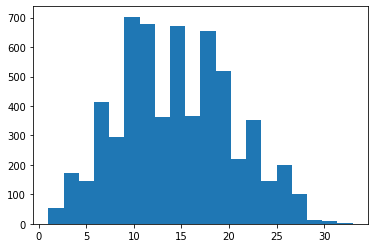

In [20]:
plt.hist(seq_lengths, bins=20)
plt.show()

Padding the sequences

In [21]:
max_length = max(seq_lengths)
X_train_padded = pad_sequences(X_train_tokenized, maxlen=max_length)
X_val_padded = pad_sequences(X_val_tokenized, maxlen=max_length)
X_test_padded = pad_sequences(X_test_tokenized, maxlen=max_length)

### Simple RNN model

In [22]:
D = 10
input = layers.Input(shape=(max_length,))
x = layers.Embedding(V+1, D)(input)
x = layers.SimpleRNN(32, return_sequences=True)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(1, activation='sigmoid')(x)
model1 = Model(input, x)

In [23]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33)]              0         
                                                                 
 embedding (Embedding)       (None, 33, 10)            157440    
                                                                 
 simple_rnn (SimpleRNN)      (None, 33, 32)            1376      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                             

In [24]:
model1.compile(
    loss='binary_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)
r1 = model1.fit(
    X_train_padded,
    y_train,
    epochs=10,
    validation_data=(X_val_padded, y_val)
)

Epoch 1/10
191/191 [==============================] - 9s 25ms/step - loss: 0.6470 - accuracy: 0.6333 - val_loss: 0.5523 - val_accuracy: 0.7065
Epoch 2/10
191/191 [==============================] - 5s 24ms/step - loss: 0.4468 - accuracy: 0.8230 - val_loss: 0.4604 - val_accuracy: 0.7958
Epoch 3/10
191/191 [==============================] - 5s 24ms/step - loss: 0.3014 - accuracy: 0.8957 - val_loss: 0.4813 - val_accuracy: 0.7938
Epoch 4/10
191/191 [==============================] - 5s 24ms/step - loss: 0.2066 - accuracy: 0.9366 - val_loss: 0.5224 - val_accuracy: 0.7925
Epoch 5/10
191/191 [==============================] - 5s 24ms/step - loss: 0.1595 - accuracy: 0.9506 - val_loss: 0.6001 - val_accuracy: 0.7722
Epoch 6/10
191/191 [==============================] - 5s 24ms/step - loss: 0.1484 - accuracy: 0.9530 - val_loss: 0.5841 - val_accuracy: 0.7669
Epoch 7/10
191/191 [==============================] - 5s 24ms/step - loss: 0.1072 - accuracy: 0.9698 - val_loss: 0.6662 - val_accuracy: 0.7715

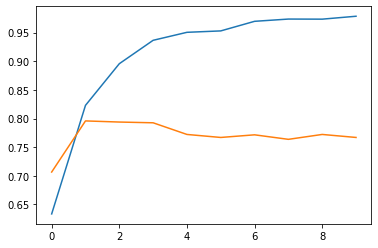

In [25]:
plt.plot(r1.history['accuracy'], label="train accuracy")
plt.plot(r1.history['val_accuracy'], label="validation accuracy")
plt.show()

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay as cmd

48/48 [==============================] - 0s 4ms/step


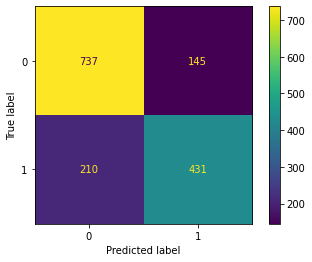

In [27]:
probs = model1.predict(X_val_padded).flatten()
y_val_pred = (probs > 0.5).astype('int')
cmd.from_predictions(y_val, y_val_pred)
plt.show()

### GRU model

In [28]:
D = 10
input = layers.Input(shape=(max_length,))
x = layers.Embedding(V+1, D)(input)
x = layers.GRU(32, return_sequences=True)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation='sigmoid')(x)
model2 = Model(input, x)

In [29]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 33)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 33, 10)            157440    
                                                                 
 gru (GRU)                   (None, 33, 32)            4224      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                           

In [30]:
model2.compile(
    loss='binary_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)
r2 = model2.fit(
    X_train_padded,
    y_train,
    epochs=10,
    validation_data=(X_val_padded, y_val)
)

Epoch 1/10
191/191 [==============================] - 6s 9ms/step - loss: 0.6719 - accuracy: 0.5829 - val_loss: 0.5628 - val_accuracy: 0.7636
Epoch 2/10
191/191 [==============================] - 1s 6ms/step - loss: 0.4481 - accuracy: 0.8102 - val_loss: 0.4417 - val_accuracy: 0.8063
Epoch 3/10
191/191 [==============================] - 1s 6ms/step - loss: 0.2795 - accuracy: 0.8975 - val_loss: 0.4744 - val_accuracy: 0.8017
Epoch 4/10
191/191 [==============================] - 1s 6ms/step - loss: 0.1842 - accuracy: 0.9414 - val_loss: 0.6074 - val_accuracy: 0.7833
Epoch 5/10
191/191 [==============================] - 1s 6ms/step - loss: 0.1277 - accuracy: 0.9603 - val_loss: 0.6270 - val_accuracy: 0.7768
Epoch 6/10
191/191 [==============================] - 1s 6ms/step - loss: 0.0985 - accuracy: 0.9690 - val_loss: 0.6774 - val_accuracy: 0.7761
Epoch 7/10
191/191 [==============================] - 1s 6ms/step - loss: 0.0799 - accuracy: 0.9742 - val_loss: 0.7479 - val_accuracy: 0.7781
Epoch 

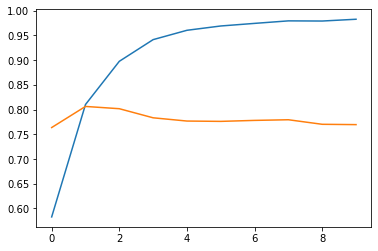

In [31]:
plt.plot(r2.history['accuracy'], label="train accuracy")
plt.plot(r2.history['val_accuracy'], label="validation accuracy")
plt.show()

48/48 [==============================] - 0s 2ms/step


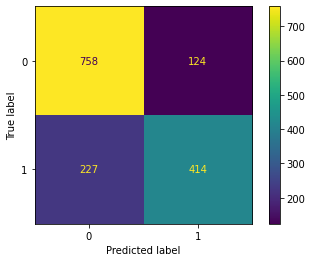

In [32]:
probs = model2.predict(X_val_padded).flatten()
y_val_pred = (probs > 0.5).astype('int')
cmd.from_predictions(y_val, y_val_pred)
plt.show()

### LSTM model

In [33]:
D = 10
input = layers.Input(shape=(max_length,))
x = layers.Embedding(V+1, D)(input)
x = layers.LSTM(32, return_sequences=True)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation='sigmoid')(x)
model3 = Model(input, x)

In [34]:
model3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 33)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 33, 10)            157440    
                                                                 
 lstm (LSTM)                 (None, 33, 32)            5504      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                           

In [35]:
model3.compile(
    loss='binary_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)
r3 = model3.fit(
    X_train_padded,
    y_train,
    epochs=10,
    validation_data=(X_val_padded, y_val)
)

Epoch 1/10
191/191 [==============================] - 3s 8ms/step - loss: 0.6624 - accuracy: 0.5972 - val_loss: 0.4996 - val_accuracy: 0.7938
Epoch 2/10
191/191 [==============================] - 1s 6ms/step - loss: 0.4354 - accuracy: 0.8228 - val_loss: 0.4480 - val_accuracy: 0.8089
Epoch 3/10
191/191 [==============================] - 1s 6ms/step - loss: 0.2925 - accuracy: 0.8944 - val_loss: 0.4862 - val_accuracy: 0.7932
Epoch 4/10
191/191 [==============================] - 1s 6ms/step - loss: 0.2080 - accuracy: 0.9333 - val_loss: 0.5583 - val_accuracy: 0.7827
Epoch 5/10
191/191 [==============================] - 1s 6ms/step - loss: 0.1521 - accuracy: 0.9539 - val_loss: 0.6158 - val_accuracy: 0.7702
Epoch 6/10
191/191 [==============================] - 1s 6ms/step - loss: 0.1253 - accuracy: 0.9652 - val_loss: 0.6000 - val_accuracy: 0.7827
Epoch 7/10
191/191 [==============================] - 1s 6ms/step - loss: 0.1043 - accuracy: 0.9711 - val_loss: 0.6193 - val_accuracy: 0.7597
Epoch 

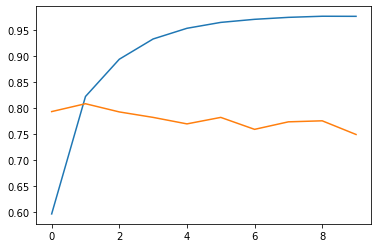

In [36]:
plt.plot(r3.history['accuracy'], label="train accuracy")
plt.plot(r3.history['val_accuracy'], label="validation accuracy")
plt.show()

48/48 [==============================] - 0s 2ms/step


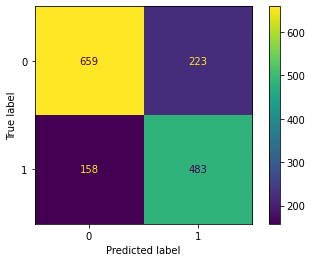

In [37]:
probs = model3.predict(X_val_padded).flatten()
y_val_pred = (probs > 0.5).astype('int')
cmd.from_predictions(y_val, y_val_pred)
plt.show()

### CNN model

In [38]:
D = 10
input = layers.Input(shape=(max_length,))
x = layers.Embedding(V+1, D)(input)
x = layers.Conv1D(32, 3)(x)
x = layers.MaxPooling1D()(x)
x = layers.Conv1D(64, 3)(x)
# x = layers.MaxPooling1D()(x)
# x = layers.Conv1D(128, 3)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation='sigmoid')(x)
model4 = Model(input, x)

In [39]:
model4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 33)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 33, 10)            157440    
                                                                 
 conv1d (Conv1D)             (None, 31, 32)            992       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 13, 64)            6208      
                                                                 
 global_max_pooling1d_3 (Glo  (None, 64)               0         
 balMaxPooling1D)                                          

In [40]:
model4.compile(
    loss='binary_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)
r4 = model4.fit(
    X_train_padded,
    y_train,
    epochs=10,
    validation_data = (X_val_padded, y_val)
)

Epoch 1/10
191/191 [==============================] - 6s 5ms/step - loss: 0.6164 - accuracy: 0.6435 - val_loss: 0.4821 - val_accuracy: 0.7768
Epoch 2/10
191/191 [==============================] - 1s 4ms/step - loss: 0.3759 - accuracy: 0.8425 - val_loss: 0.4787 - val_accuracy: 0.7932
Epoch 3/10
191/191 [==============================] - 1s 5ms/step - loss: 0.2177 - accuracy: 0.9218 - val_loss: 0.5830 - val_accuracy: 0.7853
Epoch 4/10
191/191 [==============================] - 1s 4ms/step - loss: 0.1363 - accuracy: 0.9547 - val_loss: 0.6815 - val_accuracy: 0.7623
Epoch 5/10
191/191 [==============================] - 1s 4ms/step - loss: 0.0914 - accuracy: 0.9693 - val_loss: 0.7519 - val_accuracy: 0.7682
Epoch 6/10
191/191 [==============================] - 1s 4ms/step - loss: 0.0742 - accuracy: 0.9726 - val_loss: 0.7934 - val_accuracy: 0.7656
Epoch 7/10
191/191 [==============================] - 1s 4ms/step - loss: 0.0623 - accuracy: 0.9780 - val_loss: 0.8501 - val_accuracy: 0.7682
Epoch 

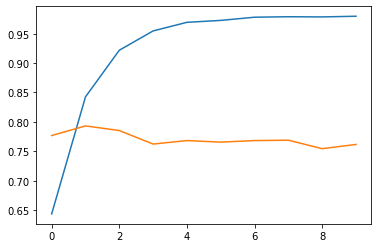

In [41]:
plt.plot(r4.history['accuracy'], label="train accuracy")
plt.plot(r4.history['val_accuracy'], label='validation accuracy')
plt.show()

48/48 [==============================] - 0s 2ms/step


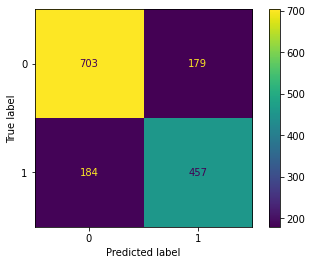

In [42]:
probs = model4.predict(X_val_padded).flatten()
y_val_pred = (probs > 0.5).astype('int')
cmd.from_predictions(y_val, y_val_pred)
plt.show()

### transformer bert

In [43]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.3 MB/s eta 0:00:00


In [44]:
from transformers import AutoTokenizer, TFAutoModel

In [45]:
checkpoint = 'bert-base-uncased'
tokenizer2 = AutoTokenizer.from_pretrained(checkpoint)
X_train_bert = tokenizer2(
    text=X_train.tolist(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_val_bert = tokenizer2(
    text=X_val.tolist(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_test_bert = tokenizer2(
    text=test_sentences.tolist(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

In [46]:
X_train_bert

{'input_ids': <tf.Tensor: shape=(6090, 33), dtype=int32, numpy=
array([[  101, 16615,  2103, ...,     0,     0,     0],
       [  101,  1045,  6118, ...,     0,     0,     0],
       [  101,  1030,  7004, ...,     0,     0,     0],
       ...,
       [  101, 19183,  9451, ...,     0,     0,     0],
       [  101,  2074,  3294, ...,     0,     0,     0],
       [  101,  6168, 15333, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(6090, 33), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [47]:
len(tokenizer2.get_vocab())

30522

In [48]:
bert_based_uncased = TFAutoModel.from_pretrained(checkpoint)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [49]:
# bert_based_uncased(X_train_bert['input_ids'][:1], attention_mask=X_train_bert['attention_mask'][:1])

In [50]:
input_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
input_mask = layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')
embeddings = bert_based_uncased(input_ids, attention_mask = input_mask)[1]
x = layers.Dropout(0.3)(embeddings)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

model5 = Model(inputs=[input_ids, input_mask], outputs=output)

In [51]:
model5.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 33)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 33)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 33,                                          

In [52]:
model5.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=5e-5, epsilon=1e-8),
    metrics=['accuracy']
)
r5 = model5.fit(
    [X_train_bert['input_ids'], X_train_bert['attention_mask']],
    y_train,
    epochs=10,
    validation_data=([X_val_bert['input_ids'], X_val_bert['attention_mask']], y_val)
)

Epoch 1/10
191/191 [==============================] - 31s 82ms/step - loss: 0.4958 - accuracy: 0.7724 - val_loss: 0.4262 - val_accuracy: 0.8207
Epoch 2/10
191/191 [==============================] - 12s 64ms/step - loss: 0.3541 - accuracy: 0.8614 - val_loss: 0.4150 - val_accuracy: 0.8267
Epoch 3/10
191/191 [==============================] - 12s 64ms/step - loss: 0.2434 - accuracy: 0.9112 - val_loss: 0.4604 - val_accuracy: 0.8286
Epoch 4/10
191/191 [==============================] - 12s 64ms/step - loss: 0.1619 - accuracy: 0.9440 - val_loss: 0.4604 - val_accuracy: 0.8162
Epoch 5/10
191/191 [==============================] - 12s 64ms/step - loss: 0.1101 - accuracy: 0.9627 - val_loss: 0.7348 - val_accuracy: 0.8089
Epoch 6/10
191/191 [==============================] - 12s 64ms/step - loss: 0.0823 - accuracy: 0.9698 - val_loss: 0.8573 - val_accuracy: 0.8148
Epoch 7/10
191/191 [==============================] - 12s 64ms/step - loss: 0.0869 - accuracy: 0.9667 - val_loss: 0.8822 - val_accuracy:

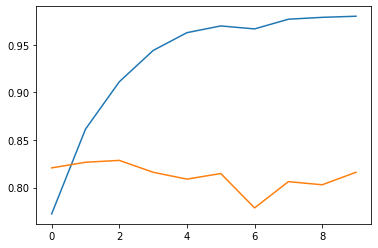

In [53]:
plt.plot(r5.history['accuracy'], label="train accuracy")
plt.plot(r5.history['val_accuracy'], label="validation accuracy")
plt.show()

48/48 [==============================] - 4s 29ms/step


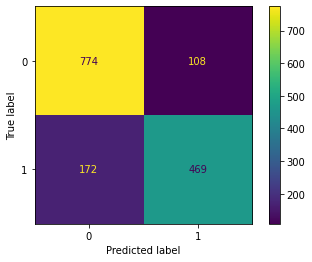

In [54]:
probs = model5.predict([X_val_bert['input_ids'], X_val_bert['attention_mask']]).flatten()
y_val_pred = (probs > 0.5).astype('int')
cmd.from_predictions(y_val, y_val_pred)
plt.show()

Among the above tested models, BERT has the best performance. The first 4 models give a validation accuracy of around 0.76, while BERT model has a validation accuracy of 0.82.

###  Combine the predictions from different model

48/48 [==============================] - 1s 29ms/step


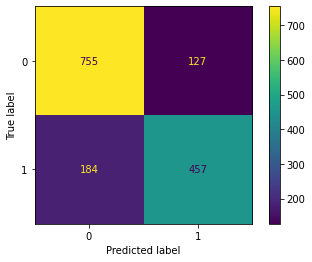

In [55]:
trained_models = [model1, model2, model3, model4]
cul_vote = 0
for m in trained_models:
  probs = m.predict(X_val_padded).flatten()
  #calculate weighted average. The weight for model1 to model4 is 0.15 and 0.4 for model5
  cul_vote += (probs > 0.5).astype('int') * 0.15

probs = model5.predict([X_val_bert['input_ids'], X_val_bert['attention_mask']]).flatten()
cul_vote += (probs > 0.5).astype('int') * 0.4
y_val_pred = (cul_vote > 0.5).astype('int')
cmd.from_predictions(y_val, y_val_pred)
plt.show()

I tried to combine the predictions of all five different models to improve the accuracy. I used weighted average. However, the combined prediction is less accurate than the BERT model alone.

### Distilbert-base-uncased

In [56]:
checkpoint2 = 'distilbert-base-uncased'

In [57]:
distilbert_tokernizer = AutoTokenizer.from_pretrained(checkpoint2)

In [58]:
X_train_distilbert = distilbert_tokernizer(
    text=X_train.tolist(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_val_distilbert = distilbert_tokernizer(
    text=X_val.tolist(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

In [59]:
X_train_distilbert

{'input_ids': <tf.Tensor: shape=(6090, 33), dtype=int32, numpy=
array([[  101, 16615,  2103, ...,     0,     0,     0],
       [  101,  1045,  6118, ...,     0,     0,     0],
       [  101,  1030,  7004, ...,     0,     0,     0],
       ...,
       [  101, 19183,  9451, ...,     0,     0,     0],
       [  101,  2074,  3294, ...,     0,     0,     0],
       [  101,  6168, 15333, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(6090, 33), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [60]:
X_train_distilbert[:1]

[Encoding(num_tokens=33, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])]

In [61]:
pretrained_distilbert = TFAutoModel.from_pretrained(checkpoint2)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [62]:
pretrained_distilbert.summary()

Model: "tf_distil_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
Total params: 66,362,880
Trainable params: 66,362,880
Non-trainable params: 0
_________________________________________________________________


In [63]:
pretrained_distilbert(X_train_distilbert['input_ids'][:1], attention_mask=X_train_distilbert['attention_mask'][:1])

TFBaseModelOutput(last_hidden_state=<tf.Tensor: shape=(1, 33, 768), dtype=float32, numpy=
array([[[ 0.04529772, -0.0960282 , -0.35963678, ..., -0.0209066 ,
          0.44535825,  0.21951608],
        [ 0.64782715,  0.56396395, -0.59351593, ...,  0.4294563 ,
          0.4301719 , -0.5070138 ],
        [-0.05014191, -0.151963  , -0.3647353 , ...,  0.14257215,
          0.5312538 , -0.64537233],
        ...,
        [ 0.24608532,  0.11991222,  0.01289895, ...,  0.08362955,
          0.20031175, -0.18865235],
        [ 0.19486758,  0.0573731 ,  0.16613734, ...,  0.04800468,
          0.19618951, -0.22010611],
        [ 0.04831738, -0.00487791,  0.22368753, ..., -0.03691207,
          0.13716003, -0.14527504]]], dtype=float32)>, hidden_states=None, attentions=None)

In [64]:
input_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
input_mask = layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')
embeddings = pretrained_distilbert(input_ids, attention_mask = input_mask)[0]
x = layers.GlobalMaxPooling1D()(embeddings)
x = layers.Dropout(0.4)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(32, activation='relu')(x)
# x = layers.Dropout(0.3)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model6 = Model(inputs=[input_ids, input_mask], outputs=output)

In [65]:
model6.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 33)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 33)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 33, 768),                                                    
                                 hidden_states=None                                         

In [66]:
model6.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=5e-5, epsilon=1e-8),
    metrics=['accuracy']
)
r6 = model6.fit(
    [X_train_distilbert['input_ids'], X_train_distilbert['attention_mask']],
    y_train,
    epochs=10,
    validation_data=([X_val_distilbert['input_ids'], X_val_distilbert['attention_mask']], y_val)
)

Epoch 1/10
191/191 [==============================] - 16s 43ms/step - loss: 0.4999 - accuracy: 0.7711 - val_loss: 0.3953 - val_accuracy: 0.8253
Epoch 2/10
191/191 [==============================] - 7s 35ms/step - loss: 0.3609 - accuracy: 0.8609 - val_loss: 0.4755 - val_accuracy: 0.8017
Epoch 3/10
191/191 [==============================] - 7s 35ms/step - loss: 0.2721 - accuracy: 0.8989 - val_loss: 0.5021 - val_accuracy: 0.8240
Epoch 4/10
191/191 [==============================] - 7s 35ms/step - loss: 0.1793 - accuracy: 0.9343 - val_loss: 0.5517 - val_accuracy: 0.8004
Epoch 5/10
191/191 [==============================] - 7s 35ms/step - loss: 0.1197 - accuracy: 0.9558 - val_loss: 0.8312 - val_accuracy: 0.7446
Epoch 6/10
191/191 [==============================] - 7s 35ms/step - loss: 0.0859 - accuracy: 0.9685 - val_loss: 0.7796 - val_accuracy: 0.8017
Epoch 7/10
191/191 [==============================] - 7s 35ms/step - loss: 0.0702 - accuracy: 0.9754 - val_loss: 0.8738 - val_accuracy: 0.787

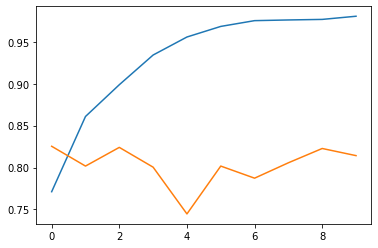

In [67]:
plt.plot(r6.history['accuracy'], label="train accuracy")
plt.plot(r6.history['val_accuracy'], label="validation accuracy")
plt.show()

48/48 [==============================] - 2s 16ms/step


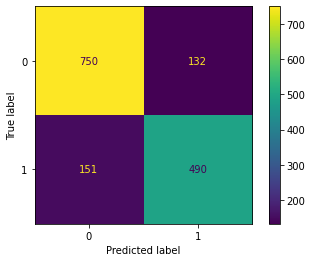

In [68]:
probs = model6.predict([X_val_distilbert['input_ids'], X_val_distilbert['attention_mask']]).flatten()
y_val_pred = (probs > 0.5).astype('int')
cmd.from_predictions(y_val, y_val_pred)
plt.show()

Distilbert model is faster to train, but the validation accuracy is not better than BERT model.

### Final model

Use the whole training dataset to train the BERT model, predict the test data target, and prepare submission data file

In [69]:
final_model = 'bert-base-uncased'
final_tokenizer = AutoTokenizer.from_pretrained(final_model)
X_train_final = final_tokenizer(
    text = train_sentences.tolist(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)
X_test_final = final_tokenizer(
    text = test_sentences.tolist(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

In [70]:
bert_final = TFAutoModel.from_pretrained(final_model)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [71]:
input_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
input_mask = layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')
embeddings = bert_final(input_ids, attention_mask = input_mask)[1]
x = layers.Dropout(0.3)(embeddings)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

model7 = Model(inputs=[input_ids, input_mask], outputs=output)

In [72]:
model7.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=5e-5, epsilon=1e-8),
    metrics=['accuracy']
)
r7 = model7.fit(
    [X_train_final['input_ids'], X_train_final['attention_mask']],
    y,
    epochs=10,
    validation_split=0.15
)

Epoch 1/10
203/203 [==============================] - 31s 76ms/step - loss: 0.5137 - accuracy: 0.7461 - val_loss: 0.3821 - val_accuracy: 0.8266
Epoch 2/10
203/203 [==============================] - 12s 61ms/step - loss: 0.3566 - accuracy: 0.8600 - val_loss: 0.4036 - val_accuracy: 0.8345
Epoch 3/10
203/203 [==============================] - 12s 61ms/step - loss: 0.2849 - accuracy: 0.8929 - val_loss: 0.4245 - val_accuracy: 0.8292
Epoch 4/10
203/203 [==============================] - 12s 61ms/step - loss: 0.1988 - accuracy: 0.9326 - val_loss: 0.4483 - val_accuracy: 0.8030
Epoch 5/10
203/203 [==============================] - 12s 61ms/step - loss: 0.1311 - accuracy: 0.9560 - val_loss: 0.5175 - val_accuracy: 0.8187
Epoch 6/10
203/203 [==============================] - 12s 61ms/step - loss: 0.1093 - accuracy: 0.9606 - val_loss: 0.6051 - val_accuracy: 0.8170
Epoch 7/10
203/203 [==============================] - 12s 61ms/step - loss: 0.0807 - accuracy: 0.9688 - val_loss: 0.8650 - val_accuracy:

In [73]:
probs = model7.predict([X_test_final['input_ids'], X_test_final['attention_mask']]).flatten()
y_pred_bert = (probs > 0.5).astype('int')
output_df = pd.DataFrame({
    'id': test_df['id'],
    'target': y_pred_bert
})
output_df.to_csv(path + 'submission.csv', index=False)

102/102 [==============================] - 6s 29ms/step
